In [19]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

In [2]:
llm=ChatGroq(model="llama-3.1-8b-instant")

In [3]:
class State(TypedDict):
    linkedin_topic: str
    generated_post: Annotated[List[str], add_messages]
    human_feedback: Annotated[List[str], add_messages]

In [4]:
def model(state: State):
    """
        Here, we're using the LLM to generate a LinkedIn Post with human feedback incorporated
    """
    
    print("[model] Generating content")
    linkedin_topic=state['linkedin_topic']
    feedback= state['human_feedback'][-1].content if state['human_feedback'] else "No Feedback Yet"

    # Here we define the prompt
    prompt=f"""

    LinkedIn Topic: {linkedin_topic}
    Human Feedback: {feedback}

    Generate a structured and well written LinkedIn post based on the given topic

    Consider previous human feedback to refine the response
    """
    response=llm.invoke(input=[
        SystemMessage(content="You are an expert LinkedIn content writer"),
        HumanMessage(content=prompt)
    ])

    generated_linkedin_post=response.content

    print(f"Model Node generated post:\n {generated_linkedin_post}")
    
    model_payload={
        "generated_post": [AIMessage(content=generated_linkedin_post)],
        "human_feedback": [feedback]
    }
    print(f"Present State: {model_payload}\n")
    
    return model_payload

    

In [5]:
def human_node(state:State):
    """
        Human Intervention node - loops back to model unless input is done
    """
    print("\n [human_node] awaiting human feedback...")
    generated_post=state["generated_post"][-1]
    
    # Interrupt to get user feedback
    user_feedback=interrupt(
        value={
            "generated_post":generated_post,
            "message":"Provide feedback or type 'done' to finish"
        }
    )

    print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.casefold()=="done":
        return Command(
                    update={"human_feedback":["Finalised"]},
                    goto="end_node"
                )
    else:
        return Command(
                    update={"human_feedback": [user_feedback]},
                    goto="model"
                )

In [6]:
def end_node(state:State):
    """
     Final Node
    """
    # print("\n[end_node] Process finished")
    print(f"Final Generated Post: {state['generated_post'][-1].content}")
    print(f"Final Human feedback: {state['human_feedback'][-1].content}")
    return {
        "generated_post":state["generated_post"][-1].content,
        "human_feedback":state["human_feedback"][-1].content
    }    

In [7]:
graph=StateGraph(state_schema=State)

In [8]:
graph.add_node(node="model",action=model)

In [9]:
graph.add_node(node="human_node",action=human_node)

In [10]:
graph.set_entry_point(key="model")

In [11]:
graph.add_node(node="end_node",action=end_node)

In [12]:
graph.add_edge(start_key=START,end_key="model")

In [13]:
graph.add_edge(start_key="model",end_key="human_node")

In [14]:
graph.set_finish_point(key="end_node")

In [15]:
checkpointer=MemorySaver()

In [16]:
app=graph.compile(checkpointer=checkpointer)

In [17]:
thread_config={
    "configurable":{"thread_id":uuid.uuid4()}
    }

In [18]:
app.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
       *       
       *       
       *       
  +-------+    
  | model |    
  +-------+    
       *       
       *       
       *       
+------------+ 
| human_node | 
+------------+ 
       *       
       *       
       *       
  +---------+  
  | __end__ |  
  +---------+  


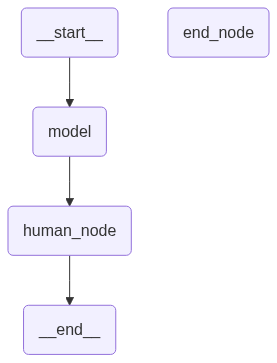

In [20]:
display(Image(data=app.get_graph().draw_mermaid_png()))

In [21]:
linkedin_topic=input("Enter your Linkedin topic: ")
initial_state={
    "linkedin_topic":linkedin_topic,
    "generated_post":[],
    "human_feedback":[]
}

In [22]:
initial_state

{'linkedin_topic': 'New Job Opportunity with AI !',
 'generated_post': [],
 'human_feedback': []}

In [ ]:
for chunk in app.stream(input=initial_state, config=thread_config):
    for node_id, value in chunk.items():
        # If we reach an interrupt, continously ask for human feedback
        if (node_id=="__interrupt__"):
            while True:
                user_feedback=input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                app.invoke(input=Command(resume=user_feedback),config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower()=="done":
                    break

[model] Generating content
Model Node generated post:
 Here's a structured and well-written LinkedIn post based on the topic "New Job Opportunity with AI!" Since there's no previous human feedback, I'll create a post that's engaging, informative, and optimized for LinkedIn's algorithm.

**New Job Opportunity: Unlock the Power of AI!**

Exciting news! I'm thrilled to announce a new job opportunity that combines cutting-edge technology with human expertise. As a [Your Profession/Industry], I'm seeking a talented individual to join our team and help us revolutionize the way we work with AI.

**Job Title:** AI Implementation Specialist

**Job Description:**

We're looking for a skilled AI Implementation Specialist to join our team and help us integrate AI-powered solutions into our business operations. The successful candidate will be responsible for:

- Designing and implementing AI-driven workflows
- Collaborating with cross-functional teams to identify areas for AI-driven innovation
- A